# Data Split

In [1]:
import os
import shutil
import random
from pathlib import Path

# ------------------------------
# CONFIG
# ------------------------------
data_dir = "/kaggle/input/balanced9class"          
output_dir = "/kaggle/working/splited"  
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
seed = 42 

random.seed(seed)
os.makedirs(output_dir, exist_ok=True)

classes = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]

for cls in classes:
    class_dir = Path(data_dir) / cls
    images = list(class_dir.glob("*"))

    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train+n_val],
        "test": images[n_train+n_val:]
    }

    for split, files in splits.items():
        split_dir = Path(output_dir) / split / cls
        split_dir.mkdir(parents=True, exist_ok=True)

        for f in files:
            shutil.copy(f, split_dir / f.name)

    print(f"[{cls}] -> Train: {n_train}, Val: {n_val}, Test: {n_test}") 

[02 Higher density ] -> Train: 800, Val: 100, Test: 100
[06 Encapsulated lesions] -> Train: 800, Val: 100, Test: 100
[01 Pneumonia] -> Train: 800, Val: 100, Test: 100
[00 Normal] -> Train: 800, Val: 100, Test: 100
[03 Lower density] -> Train: 800, Val: 100, Test: 100
[07 Mediastinal changes] -> Train: 800, Val: 100, Test: 100
[05 Degenerative infectious diseases] -> Train: 800, Val: 100, Test: 100
[04 Obstructive pulmonary diseases] -> Train: 800, Val: 100, Test: 100
[08 Chest changes] -> Train: 800, Val: 100, Test: 100


# Data Loader

In [81]:
import os
import tensorflow as tf
import numpy as np

base_dir   = '/kaggle/working/splited'
img_size   = (224, 224)
batch_size = 48
seed       = 42

tf.random.set_seed(seed)
np.random.seed(seed)

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

def preprocess(image, label):
    #image = tf.image.rgb_to_grayscale(image)   
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

# Apply preprocessing
train_ds = train_ds_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

print(f"Class names: {train_ds_raw.class_names}")
print(f"Number of classes: {len(train_ds_raw.class_names)}") 

Found 7200 files belonging to 9 classes.
Found 900 files belonging to 9 classes.
Found 900 files belonging to 9 classes.
Class names: ['00 Normal', '01 Pneumonia', '02 Higher density ', '03 Lower density', '04 Obstructive pulmonary diseases', '05 Degenerative infectious diseases', '06 Encapsulated lesions', '07 Mediastinal changes', '08 Chest changes']
Number of classes: 9


In [3]:
import numpy as np
from sklearn.metrics import roc_auc_score

def evaluate_model_with_auc(model, dataset, dataset_name="Dataset"):
    
    # 1. Standard model.evaluate() for loss and accuracy
    loss, accuracy = model.evaluate(dataset, verbose=0)

    # 2. Predict probabilities and get true labels
    y_true = []
    y_pred = []

    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch.numpy())
        y_pred.append(preds)

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # 3. Compute macro AUC for multi-class classification
    auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')

    # 4. Print results
    print(f"{dataset_name} Loss: {loss:.4f}")
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} AUC (macro): {auc:.4f}")

    return {
        "loss": loss,
        "accuracy": accuracy,
        "auc_macro": auc
    }

In [68]:
import os
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="Model", figsize=(14, 5), style="seaborn-v0_8", dpi=300, save_path=None):
   
    plt.style.use(style)
    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linewidth=1.5)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linewidth=1.5)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight="bold")
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', color='#2ca02c', linewidth=1.5)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='#d62728', linewidth=1.5)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight="bold")
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        file_path = os.path.join(save_path, f"{model_name}_training_curves.png")
        plt.savefig(file_path, dpi=dpi, bbox_inches="tight")
        print(f"✅ Plot saved at: {file_path}")

    plt.show()


# Classifier Head Ablation

**GlobalMaxPooling2D**

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_lightxraynet_mxp(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)
    
model = build_lightxraynet_mxp()

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30


I0000 00:00:1757252902.553747     100 service.cc:148] XLA service 0x7de4f4006e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757252902.554516     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757252903.223103     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0774 - loss: 7.0029  

I0000 00:00:1757252908.987498     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2042 - loss: 3.0788 - val_accuracy: 0.1111 - val_loss: 3.9506 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4525 - loss: 1.5877 - val_accuracy: 0.1767 - val_loss: 2.2083 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5805 - loss: 1.2297 - val_accuracy: 0.7556 - val_loss: 0.8611 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6613 - loss: 0.9883 - val_accuracy: 0.8278 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7280 - loss: 0.7980 - val_accuracy: 0.8467 - val_loss: 0.4974 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7842 - loss: 0.6454 - val_accuracy: 0.8833 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7991 - loss: 0.5806 - val

**Flatten**

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_lightxraynet_fltn(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)
    
model = build_lightxraynet_fltn()

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.4371 - loss: 2.9782 - val_accuracy: 0.2000 - val_loss: 3.1562 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8286 - loss: 0.5916 - val_accuracy: 0.6256 - val_loss: 1.1742 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8942 - loss: 0.3457 - val_accuracy: 0.7544 - val_loss: 0.8858 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9385 - loss: 0.2060 - val_accuracy: 0.8900 - val_loss: 0.4312 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9587 - loss: 0.1427 - val_accuracy: 0.9244 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9676 - loss: 0.1072 - val_accuracy: 0.9489 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9616 - loss: 0

**Dual Pooling**

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.ReLU()(x)
    return x


def build_lightxraynet_dual(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp  
    
    # Stem - smaller
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)

    
    # Block 1 (56x56) - fewer filters
    x = conv_block(x, 48, k=3, s=1, name="b1_1")   # was 64
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2 (28x28) - fewer filters
    x = conv_block(x, 72, k=3, s=1, name="b2_1")   # was 96
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 3 (14x14) - fewer filters
    x = conv_block(x, 128, k=3, s=1, name="b3_1")  # was 144
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head with dual pooling
    avg_pool = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    max_pool = layers.GlobalMaxPooling2D(name="max_pool")(x)
    x = layers.Concatenate(name="dual_pool")([avg_pool, max_pool])
    
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)

model = build_lightxraynet_dual() 

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1124 - loss: 2.1966 - val_accuracy: 0.1256 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1581 - loss: 2.1510 - val_accuracy: 0.4167 - val_loss: 1.6661 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4350 - loss: 1.5965 - val_accuracy: 0.6344 - val_loss: 1.1437 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6240 - loss: 1.1313 - val_accuracy: 0.7878 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7506 - loss: 0.7608 - val_accuracy: 0.8622 - val_loss: 0.4893 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8220 - loss: 0.5295 - val_accuracy: 0.8900 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8474 - loss: 0.

**GlobalAveragePooing**

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_lightxraynet_avg(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)
    
model = build_lightxraynet_avg()

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.3010 - loss: 1.9757 - val_accuracy: 0.1111 - val_loss: 9.5876 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5485 - loss: 1.3348 - val_accuracy: 0.1578 - val_loss: 3.9699 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6476 - loss: 1.0565 - val_accuracy: 0.3822 - val_loss: 1.7871 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7322 - loss: 0.8246 - val_accuracy: 0.5567 - val_loss: 1.1101 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7926 - loss: 0.6618 - val_accuracy: 0.6778 - val_loss: 1.0193 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8532 - loss: 0.4932 - val_accuracy: 0.4022 - val_loss: 2.3626 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8786 - loss: 0

# Optimizer Ablation

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_lightxraynet_avg(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)
    
model = build_lightxraynet_avg()

In [16]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.1729 - loss: 2.1949 - val_accuracy: 0.1111 - val_loss: 4.6719 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2902 - loss: 1.9358 - val_accuracy: 0.1122 - val_loss: 4.7394 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3668 - loss: 1.7769 - val_accuracy: 0.2011 - val_loss: 2.1968 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4148 - loss: 1.6573 - val_accuracy: 0.5356 - val_loss: 1.5164 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4554 - loss: 1.5669 - val_accuracy: 0.2489 - val_loss: 1.9895 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4975 - loss: 1.4863 - val_accuracy: 0.5367 - val_loss: 1.3965 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5299 - loss: 1

In [18]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, centered=False),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test")

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.2527 - loss: 2.0812 - val_accuracy: 0.1622 - val_loss: 7.9794 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4859 - loss: 1.4339 - val_accuracy: 0.2000 - val_loss: 5.4136 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6229 - loss: 1.0995 - val_accuracy: 0.4756 - val_loss: 1.4990 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7088 - loss: 0.8408 - val_accuracy: 0.5333 - val_loss: 1.9682 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7894 - loss: 0.6039 - val_accuracy: 0.6311 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8527 - loss: 0.4542 - val_accuracy: 0.7611 - val_loss: 0.7062 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8826 - loss: 0

In [20]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test")

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.2765 - loss: 2.0286 - val_accuracy: 0.1111 - val_loss: 9.9735 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5092 - loss: 1.4505 - val_accuracy: 0.1700 - val_loss: 4.3734 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6042 - loss: 1.2168 - val_accuracy: 0.5133 - val_loss: 1.3325 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6657 - loss: 1.0508 - val_accuracy: 0.5644 - val_loss: 1.2340 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7320 - loss: 0.8754 - val_accuracy: 0.7300 - val_loss: 0.8611 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7780 - loss: 0.7358 - val_accuracy: 0.4789 - val_loss: 1.6721 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8149 - loss: 0

In [22]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test")


Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.2849 - loss: 1.9475 - val_accuracy: 0.1111 - val_loss: 12.3550 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5504 - loss: 1.3141 - val_accuracy: 0.2700 - val_loss: 1.9653 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6689 - loss: 1.0152 - val_accuracy: 0.6556 - val_loss: 1.0141 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7411 - loss: 0.7854 - val_accuracy: 0.7222 - val_loss: 0.8658 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8030 - loss: 0.6335 - val_accuracy: 0.7522 - val_loss: 0.8004 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8469 - loss: 0.4906 - val_accuracy: 0.6378 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8972 - loss: 

# Learning Rate

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_lightxraynet_avglr(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)
    
model = build_lightxraynet_avglr()

In [24]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test")

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.2695 - loss: 2.0024 - val_accuracy: 0.1111 - val_loss: 6.3344 - learning_rate: 5.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5433 - loss: 1.3752 - val_accuracy: 0.1122 - val_loss: 3.8395 - learning_rate: 5.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6449 - loss: 1.1034 - val_accuracy: 0.6089 - val_loss: 1.2312 - learning_rate: 5.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7092 - loss: 0.9001 - val_accuracy: 0.6744 - val_loss: 0.9754 - learning_rate: 5.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7738 - loss: 0.7358 - val_accuracy: 0.7689 - val_loss: 0.7425 - learning_rate: 5.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8162 - loss: 0.6024 - val_accuracy: 0.8344 - val_loss: 0.5539 - learning_rate: 5.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - ac

In [26]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test")

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.2672 - loss: 2.0221 - val_accuracy: 0.1111 - val_loss: 7.8048 - learning_rate: 3.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4819 - loss: 1.4883 - val_accuracy: 0.1244 - val_loss: 3.6636 - learning_rate: 3.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5894 - loss: 1.2505 - val_accuracy: 0.5244 - val_loss: 1.3027 - learning_rate: 3.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6524 - loss: 1.0836 - val_accuracy: 0.7100 - val_loss: 1.0678 - learning_rate: 3.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7170 - loss: 0.9205 - val_accuracy: 0.7656 - val_loss: 0.8080 - learning_rate: 3.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7653 - loss: 0.7967 - val_accuracy: 0.8178 - val_loss: 0.6370 - learning_rate: 3.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - ac

In [28]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.1642 - loss: 2.2731 - val_accuracy: 0.1111 - val_loss: 5.4890 - learning_rate: 1.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3539 - loss: 1.8187 - val_accuracy: 0.1144 - val_loss: 4.6747 - learning_rate: 1.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4454 - loss: 1.5886 - val_accuracy: 0.3389 - val_loss: 1.8161 - learning_rate: 1.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5074 - loss: 1.4552 - val_accuracy: 0.6033 - val_loss: 1.3067 - learning_rate: 1.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5424 - loss: 1.3515 - val_accuracy: 0.6600 - val_loss: 1.1592 - learning_rate: 1.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5830 - loss: 1.2663 - val_accuracy: 0.6789 - val_loss: 1.0991 - learning_rate: 1.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - ac

# Activation Function

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None, alpha=0.1):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=alpha)(x)
    return x


def build_lightxraynet_avgaf(input_shape=(224,224,1), num_classes=9, alpha=0.1):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=alpha, name="stem_lrelu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1", alpha=alpha)
    x = conv_block(x, 48, k=3, s=1, name="b1_2", alpha=alpha)
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1", alpha=alpha)
    x = conv_block(x, 72, k=3, s=1, name="b2_2", alpha=alpha)
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    
    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1", alpha=alpha)
    x = conv_block(x, 128, k=3, s=1, name="b3_2", alpha=alpha)
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)
    

# Build model with LeakyReLU
model = build_lightxraynet_avgaf()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [35]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.2561 - loss: 2.0231 - val_accuracy: 0.1111 - val_loss: 9.1385 - learning_rate: 3.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4634 - loss: 1.5275 - val_accuracy: 0.1600 - val_loss: 4.8116 - learning_rate: 3.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5712 - loss: 1.2934 - val_accuracy: 0.4989 - val_loss: 1.4179 - learning_rate: 3.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6430 - loss: 1.1194 - val_accuracy: 0.6067 - val_loss: 1.1552 - learning_rate: 3.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6860 - loss: 0.9856 - val_accuracy: 0.6678 - val_loss: 0.9463 - learning_rate: 3.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7387 - loss: 0.8495 - val_accuracy: 0.7067 - val_loss: 0.8305 - learning_rate: 3.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - ac

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)   # Swish activation
    return x


def build_lightxraynet_avgsw(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish", name="stem_swish")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)

# Build model with Swish
model = build_lightxraynet_avgsw()

In [38]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.2882 - loss: 1.9540 - val_accuracy: 0.1111 - val_loss: 5.9422 - learning_rate: 3.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5195 - loss: 1.4471 - val_accuracy: 0.1756 - val_loss: 3.2236 - learning_rate: 3.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6292 - loss: 1.1642 - val_accuracy: 0.4144 - val_loss: 1.7248 - learning_rate: 3.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6998 - loss: 0.9774 - val_accuracy: 0.7467 - val_loss: 0.8291 - learning_rate: 3.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7552 - loss: 0.8181 - val_accuracy: 0.7689 - val_loss: 0.7474 - learning_rate: 3.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7913 - loss: 0.6901 - val_accuracy: 0.7100 - val_loss: 0.8302 - learning_rate: 3.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - ac

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None, alpha=1.0):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha=alpha)(x)   # ELU activation
    return x


def build_lightxraynet_avgelu(input_shape=(224,224,1), num_classes=9, alpha=1.0):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha=alpha, name="stem_elu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1", alpha=alpha)
    x = conv_block(x, 48, k=3, s=1, name="b1_2", alpha=alpha)
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1", alpha=alpha)
    x = conv_block(x, 72, k=3, s=1, name="b2_2", alpha=alpha)
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1", alpha=alpha)
    x = conv_block(x, 128, k=3, s=1, name="b3_2", alpha=alpha)
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)


# Build model with ELU
model = build_lightxraynet_avgelu()

In [41]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.2745 - loss: 2.0081 - val_accuracy: 0.1111 - val_loss: 6.0314 - learning_rate: 3.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4397 - loss: 1.5837 - val_accuracy: 0.2056 - val_loss: 2.6602 - learning_rate: 3.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5352 - loss: 1.3752 - val_accuracy: 0.4889 - val_loss: 1.4640 - learning_rate: 3.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6035 - loss: 1.2104 - val_accuracy: 0.6233 - val_loss: 1.1198 - learning_rate: 3.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6431 - loss: 1.0880 - val_accuracy: 0.6878 - val_loss: 0.9814 - learning_rate: 3.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6883 - loss: 0.9540 - val_accuracy: 0.7711 - val_loss: 0.7869 - learning_rate: 3.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - ac

# Batch Size

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)   # Swish activation
    return x


def build_lightxraynet_avgbatch(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish", name="stem_swish")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)

# Build model with Swish
model = build_lightxraynet_avgbatch()

In [44]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.3107 - loss: 1.9084 - val_accuracy: 0.1900 - val_loss: 4.8387 - learning_rate: 3.0000e-04
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5415 - loss: 1.3868 - val_accuracy: 0.5244 - val_loss: 1.3255 - learning_rate: 3.0000e-04
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6461 - loss: 1.1163 - val_accuracy: 0.5156 - val_loss: 1.3380 - learning_rate: 3.0000e-04
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7229 - loss: 0.9029 - val_accuracy: 0.7644 - val_loss: 0.7847 - learning_rate: 3.0000e-04
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7766 - loss: 0.7474 - val_accuracy: 0.8011 - val_loss: 0.6661 - learning_rate: 3.0000e-04
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8274 - loss: 0.5965 - val_accuracy: 0.6822 - val_loss: 0.8332 - learning_rate: 3.0000e-04
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - ac

In [47]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.2801 - loss: 1.9753 - val_accuracy: 0.1111 - val_loss: 3.8702 - learning_rate: 3.0000e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5130 - loss: 1.4481 - val_accuracy: 0.1111 - val_loss: 5.5592 - learning_rate: 3.0000e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6221 - loss: 1.2022 - val_accuracy: 0.1678 - val_loss: 3.5881 - learning_rate: 3.0000e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6909 - loss: 1.0060 - val_accuracy: 0.3989 - val_loss: 1.7266 - learning_rate: 3.0000e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7448 - loss: 0.8540 - val_accuracy: 0.5244 - val_loss: 1.2263 - learning_rate: 3.0000e-04
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7830 - loss: 0.7336 - val_accuracy: 0.6444 - val_loss: 0.9763 - learning_rate: 3.0000e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - ac

In [51]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.2674 - loss: 1.9857 - val_accuracy: 0.1111 - val_loss: 3.0076 - learning_rate: 3.0000e-04
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4823 - loss: 1.5092 - val_accuracy: 0.1667 - val_loss: 4.0409 - learning_rate: 3.0000e-04
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5909 - loss: 1.2760 - val_accuracy: 0.1633 - val_loss: 4.3824 - learning_rate: 3.0000e-04
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6558 - loss: 1.0854 - val_accuracy: 0.2356 - val_loss: 2.9683 - learning_rate: 3.0000e-04
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7182 - loss: 0.9277 - val_accuracy: 0.2822 - val_loss: 2.1884 - learning_rate: 3.0000e-04
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7677 - loss: 0.8072 - val_accuracy: 0.5267 - val_loss: 1.2974 - learning_rate: 3.0000e-04
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - ac

# Epoch

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def conv_block(x, filters, k=3, s=1, name=None):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)   
    return x


def build_lightxraynet_avge(input_shape=(224,224,1), num_classes=9):
    inp = keras.Input(shape=input_shape)
    x = inp

    # Stem
    x = layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish", name="stem_swish")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Block 1
    x = conv_block(x, 48, k=3, s=1, name="b1_1")
    x = conv_block(x, 48, k=3, s=1, name="b1_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 2
    x = conv_block(x, 72, k=3, s=1, name="b2_1")
    x = conv_block(x, 72, k=3, s=1, name="b2_2")
    x = layers.MaxPooling2D(pool_size=2, strides=2, name="pool2")(x)  
    x = layers.SpatialDropout2D(0.05)(x)

    # Block 3
    x = conv_block(x, 128, k=3, s=1, name="b3_1")
    x = conv_block(x, 128, k=3, s=1, name="b3_2")
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inp, out)

# Build model with Swish
model = build_lightxraynet_avge()

In [56]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=10,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.2676 - loss: 1.9857 - val_accuracy: 0.1111 - val_loss: 3.6043 - learning_rate: 3.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5140 - loss: 1.4450 - val_accuracy: 0.1111 - val_loss: 4.9791 - learning_rate: 3.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6166 - loss: 1.1982 - val_accuracy: 0.1822 - val_loss: 3.5332 - learning_rate: 3.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6786 - loss: 1.0176 - val_accuracy: 0.5178 - val_loss: 1.4365 - learning_rate: 3.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7306 - loss: 0.8666 - val_accuracy: 0.7244 - val_loss: 0.8667 - learning_rate: 3.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7799 - loss: 0.7492 - val_accuracy: 0.8189 - val_loss: 0.6412 - learning_rate: 3.0000e-04
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - ac

In [58]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=20,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.2800 - loss: 1.9671 - val_accuracy: 0.1111 - val_loss: 4.3179 - learning_rate: 3.0000e-04
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5130 - loss: 1.4497 - val_accuracy: 0.1111 - val_loss: 7.4091 - learning_rate: 3.0000e-04
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6144 - loss: 1.1979 - val_accuracy: 0.1578 - val_loss: 4.6201 - learning_rate: 3.0000e-04
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6849 - loss: 1.0143 - val_accuracy: 0.3267 - val_loss: 1.9953 - learning_rate: 3.0000e-04
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7273 - loss: 0.8868 - val_accuracy: 0.6122 - val_loss: 1.0750 - learning_rate: 3.0000e-04
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7820 - loss: 0.7442 - val_accuracy: 0.6089 - val_loss: 1.0720 - learning_rate: 3.0000e-04
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - ac

In [60]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.2735 - loss: 1.9809 - val_accuracy: 0.1111 - val_loss: 3.5836 - learning_rate: 3.0000e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5052 - loss: 1.4732 - val_accuracy: 0.1111 - val_loss: 5.8513 - learning_rate: 3.0000e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6043 - loss: 1.2126 - val_accuracy: 0.1967 - val_loss: 2.7748 - learning_rate: 3.0000e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6909 - loss: 1.0223 - val_accuracy: 0.5289 - val_loss: 1.3811 - learning_rate: 3.0000e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7445 - loss: 0.8657 - val_accuracy: 0.6656 - val_loss: 0.9965 - learning_rate: 3.0000e-04
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7822 - loss: 0.7323 - val_accuracy: 0.7233 - val_loss: 0.8525 - learning_rate: 3.0000e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - ac

In [64]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=40,
    verbose=1
)

val_results = evaluate_model_with_auc(model, val_ds, "Validation")
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.2706 - loss: 1.9767 - val_accuracy: 0.1111 - val_loss: 4.0544 - learning_rate: 3.0000e-04
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5096 - loss: 1.4460 - val_accuracy: 0.1111 - val_loss: 6.4711 - learning_rate: 3.0000e-04
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6081 - loss: 1.2218 - val_accuracy: 0.1822 - val_loss: 4.6027 - learning_rate: 3.0000e-04
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6691 - loss: 1.0582 - val_accuracy: 0.2578 - val_loss: 2.6252 - learning_rate: 3.0000e-04
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7186 - loss: 0.9099 - val_accuracy: 0.7944 - val_loss: 0.8029 - learning_rate: 3.0000e-04
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7788 - loss: 0.7603 - val_accuracy: 0.7589 - val_loss: 0.7628 - learning_rate: 3.0000e-04
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - ac

In [69]:
# Save model as .h5
model.save("/kaggle/working/LightXRayNet.h5")

print("✅ Model saved as /kaggle/working/LightXRayNet.h5")

✅ Model saved as /kaggle/working/LightXRayNet.h5


✅ Plot saved at: /kaggle/working/LightXRayNet_training_curves.png


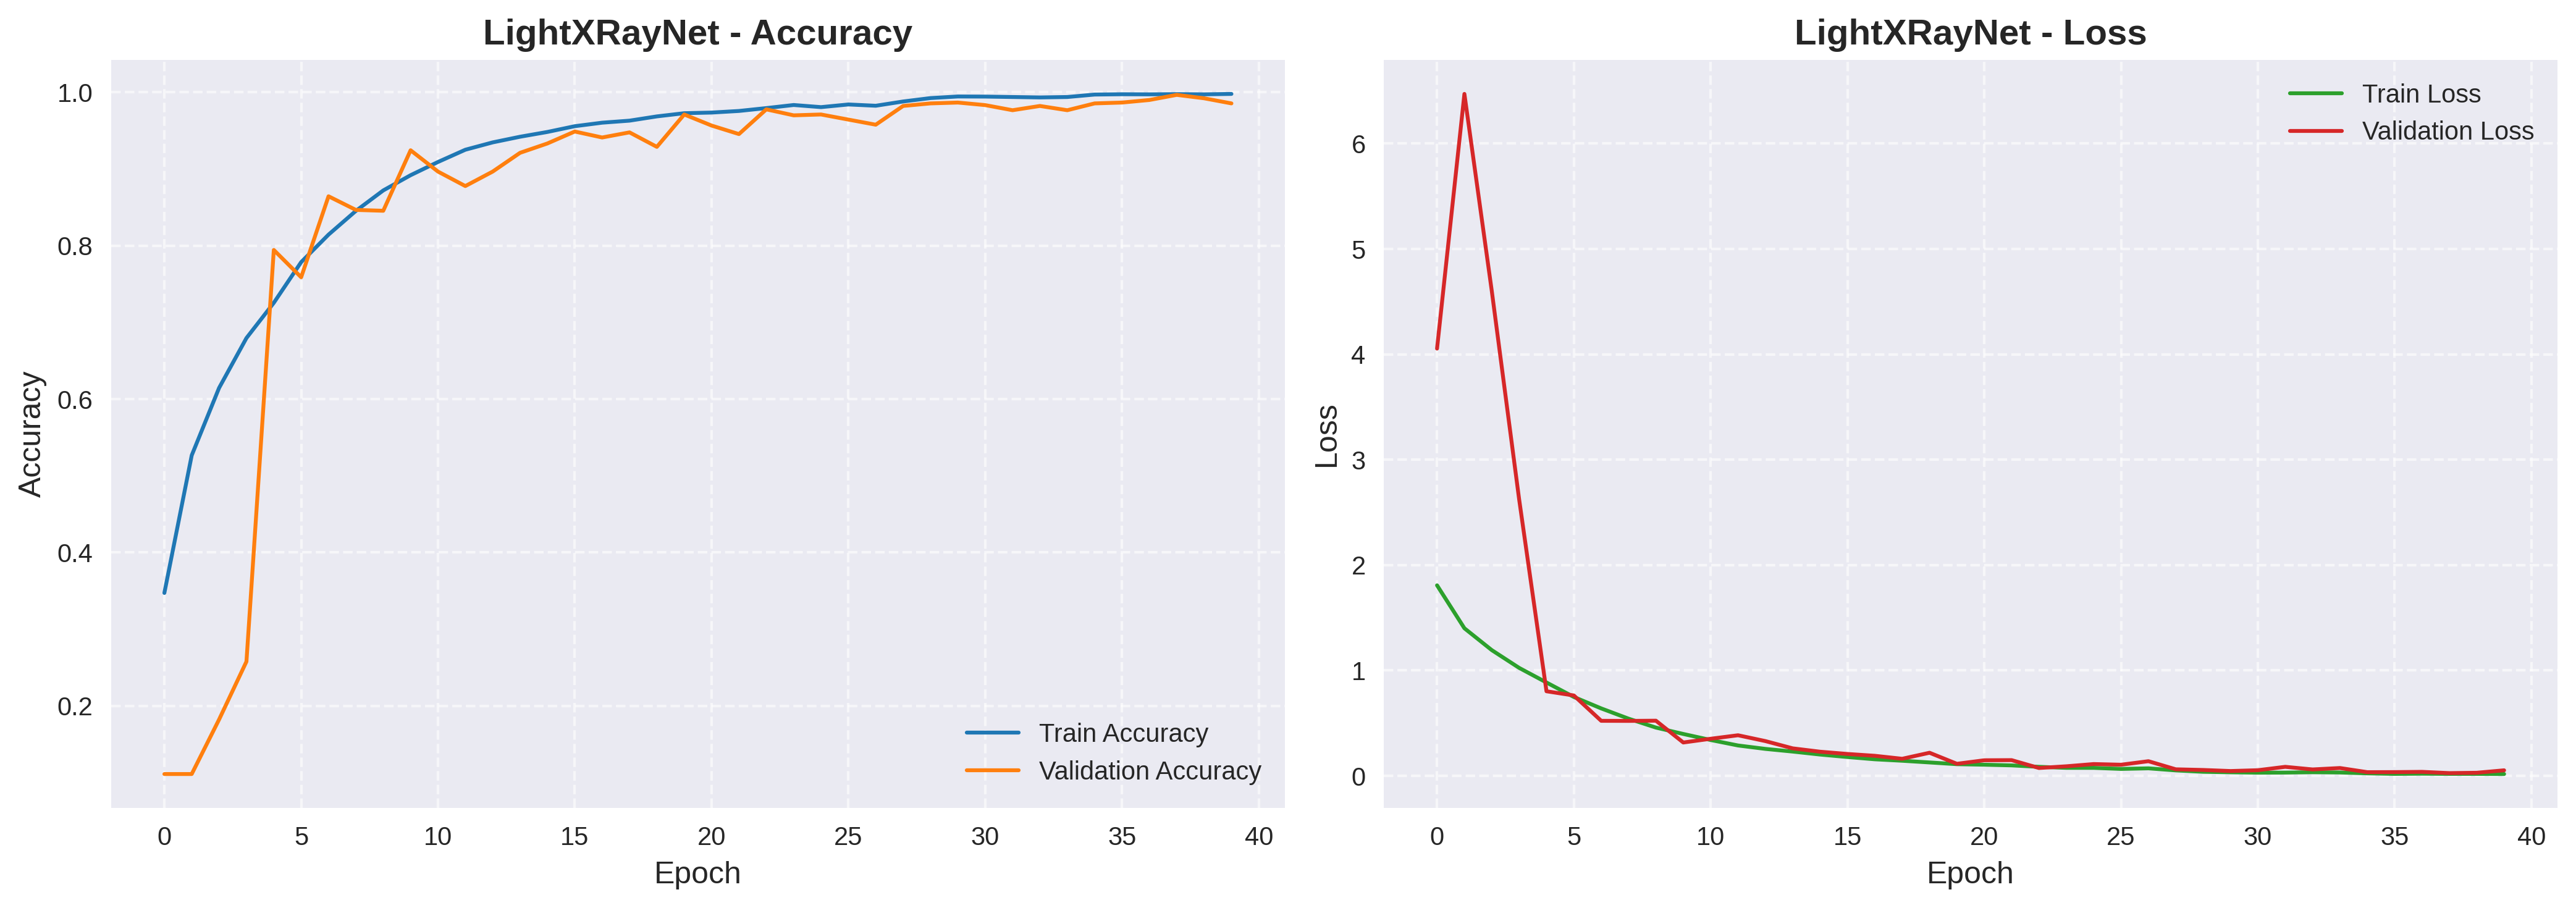

In [70]:
plot_training_curves(history, model_name="LightXRayNet", save_path="/kaggle/working")

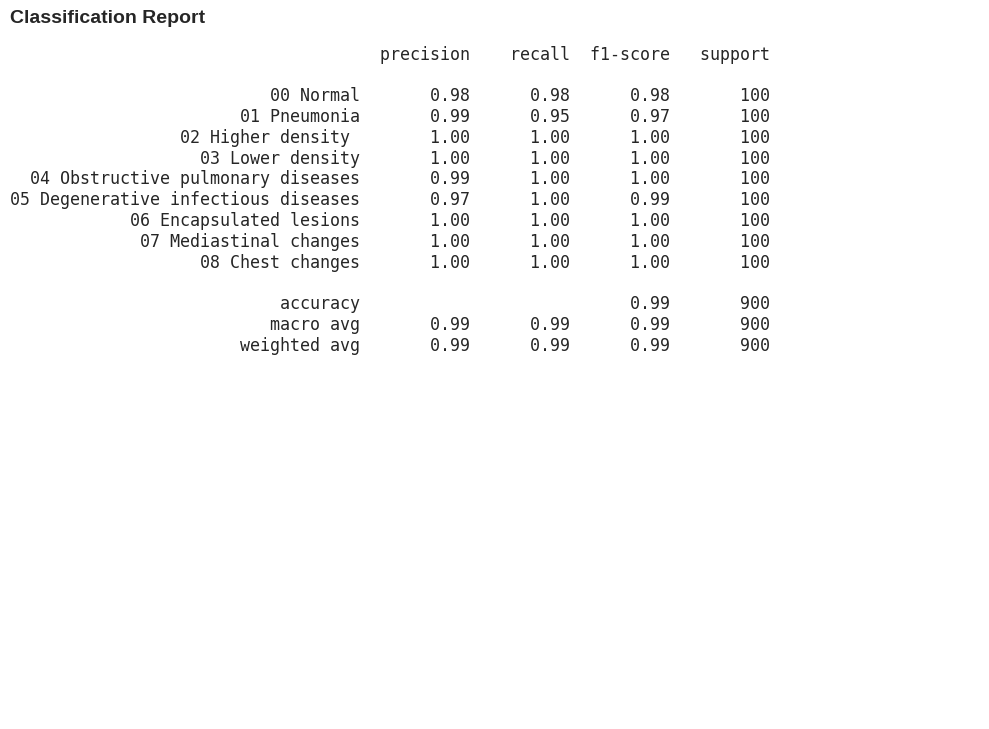

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

def save_classification_report(model, dataset, class_names, save_path="classification_report.png"):
 
    # Get true labels and predictions
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred_probs = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    
    # Generate classification report
    report = classification_report(y_true_labels, y_pred, target_names=class_names, output_dict=True)
    
    # Convert report to text for display
    report_text = classification_report(y_true_labels, y_pred, target_names=class_names)
    
    # Plot report as figure
    plt.figure(figsize=(10, len(class_names)*0.6 + 2))
    plt.text(0, 1, "Classification Report", fontsize=14, fontweight='bold', va='top')
    plt.text(0, 0.95, report_text, fontsize=12, fontfamily='monospace', va='top')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Example usage:
class_names = train_ds_raw.class_names
save_classification_report(model, test_ds, class_names, save_path="classification_report.png")

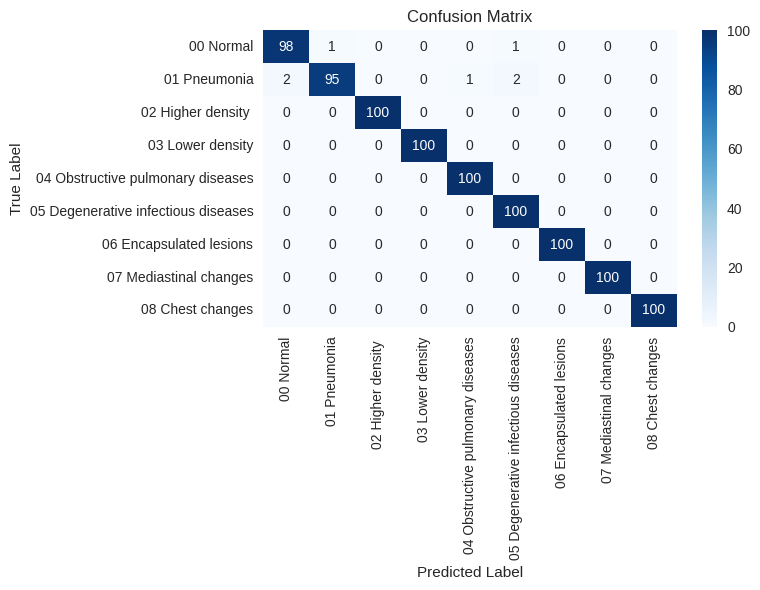

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def save_confusion_matrix(model, dataset, class_names, save_path="confusion_matrix.png"):
 
    # Get true labels and predictions
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred_probs = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred)
    
    # Plot as heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Example usage:
class_names = train_ds_raw.class_names
save_confusion_matrix(model, test_ds, class_names, save_path="confusion_matrix.png")

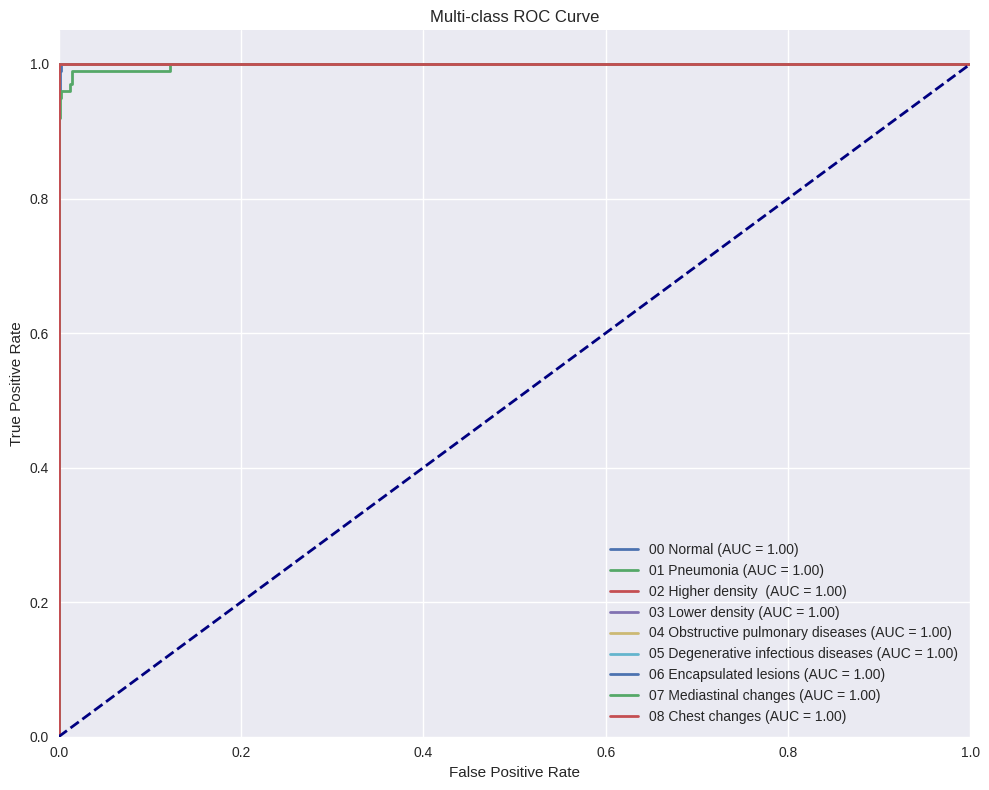

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def save_auc_roc(model, dataset, class_names, save_path="auc_roc.png"):
   
    # Get true labels and predictions
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred = model.predict(dataset, verbose=0)
    
    n_classes = len(class_names)
    
    # Ensure y_true is one-hot encoded
    if y_true.shape[1] != n_classes:
        y_true = label_binarize(y_true, classes=range(n_classes))
    
    # Plot ROC for each class
    plt.figure(figsize=(10,8))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Plot diagonal line
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(save_path)
    plt.show()

# Example usage
class_names = train_ds_raw.class_names
save_auc_roc(model, test_ds, class_names, save_path="auc_roc.png")


In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

INPUT_SHAPE = (224, 224, 3)  
NUM_CLASSES = 9

def build_inception_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, train_base=False):
    base_model = keras.applications.InceptionV3(
        include_top=False,
        weights="imagenet",    
        input_shape=input_shape,
        pooling="avg"
    )
    base_model.trainable = train_base  

    inp = keras.Input(shape=input_shape)
    x = base_model(inp, training=False)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    return model

model = build_inception_model(train_base=False) 

In [83]:
import time
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        self.total_training_time = time.time() - self.train_start_time


model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

timing_cb = TimingCallback()
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    timing_cb
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=40,
    verbose=1
)

first_epoch_time = timing_cb.epoch_times[0]
avg_epoch_time = sum(timing_cb.epoch_times) / len(timing_cb.epoch_times)
total_training_time = timing_cb.total_training_time

print(f"⏱ First epoch time: {first_epoch_time:.2f} sec")
print(f"⏱ Average epoch time: {avg_epoch_time:.2f} sec")
print(f"⏱ Total training time: {total_training_time:.2f} sec")

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test")

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.2945 - loss: 1.9686 - val_accuracy: 0.6233 - val_loss: 1.2629 - learning_rate: 3.0000e-04
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6536 - loss: 1.1775 - val_accuracy: 0.7244 - val_loss: 0.9940 - learning_rate: 3.0000e-04
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7463 - loss: 0.9326 - val_accuracy: 0.7656 - val_loss: 0.8496 - learning_rate: 3.0000e-04
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7936 - loss: 0.7913 - val_accuracy: 0.7911 - val_loss: 0.7546 - learning_rate: 3.0000e-04
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8245 - loss: 0.6950 - val_accuracy: 0.8178 - val_loss: 0.6855 - learning_rate: 3.0000e-04
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8456 - loss: 0.6235 - val_accuracy: 0.8333 - val_loss: 0.6322 - learning_rate: 3.0000e-04
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - a

✅ Model saved as /kaggle/working/InceptionV3.h5
✅ Plot saved at: /kaggle/working/InceptionV3_training_curves.png


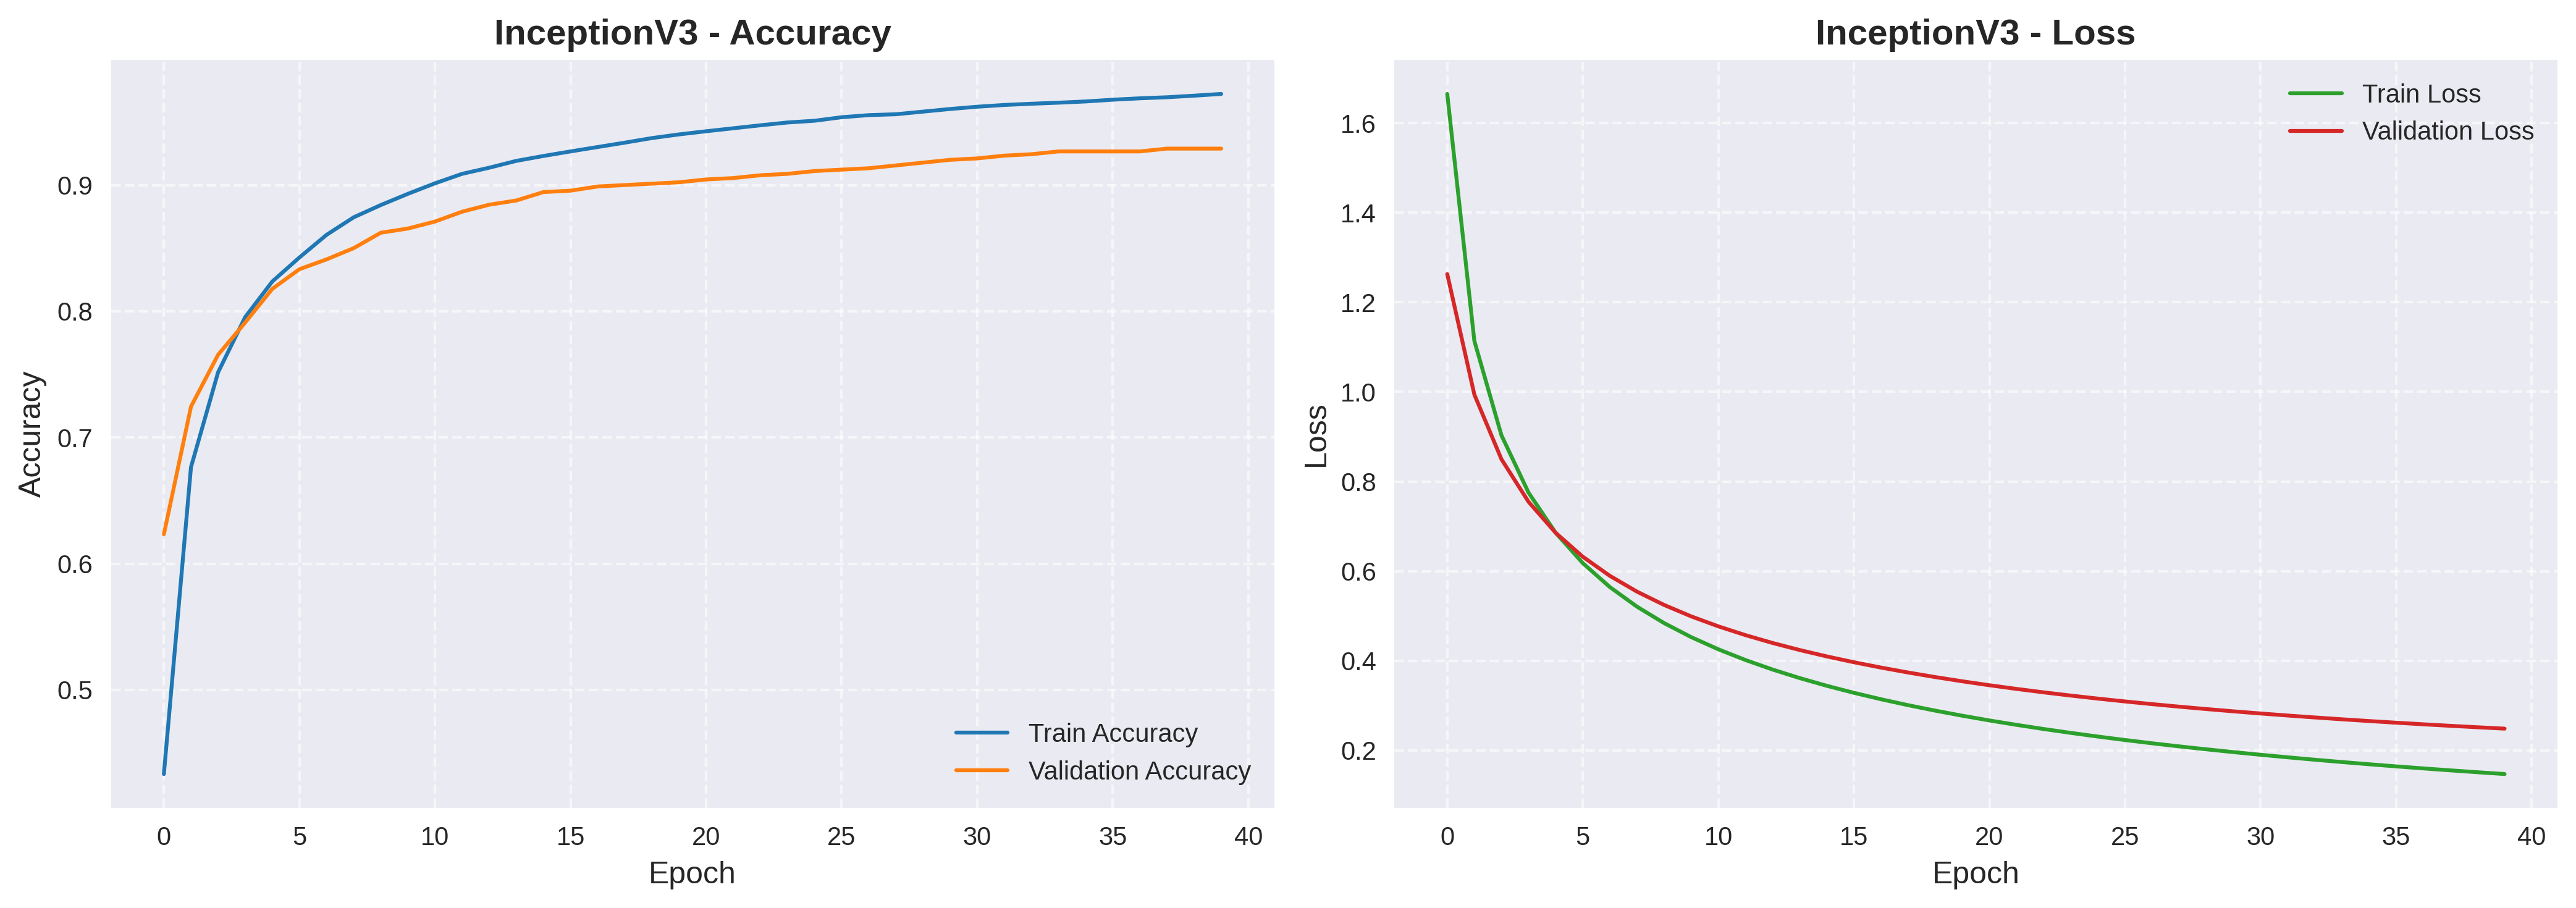

In [84]:
mname = "InceptionV3"
model.save(f"/kaggle/working/{mname}.h5")

print(f"✅ Model saved as /kaggle/working/{mname}.h5")
plot_training_curves(history, model_name=mname, save_path="/kaggle/working") 

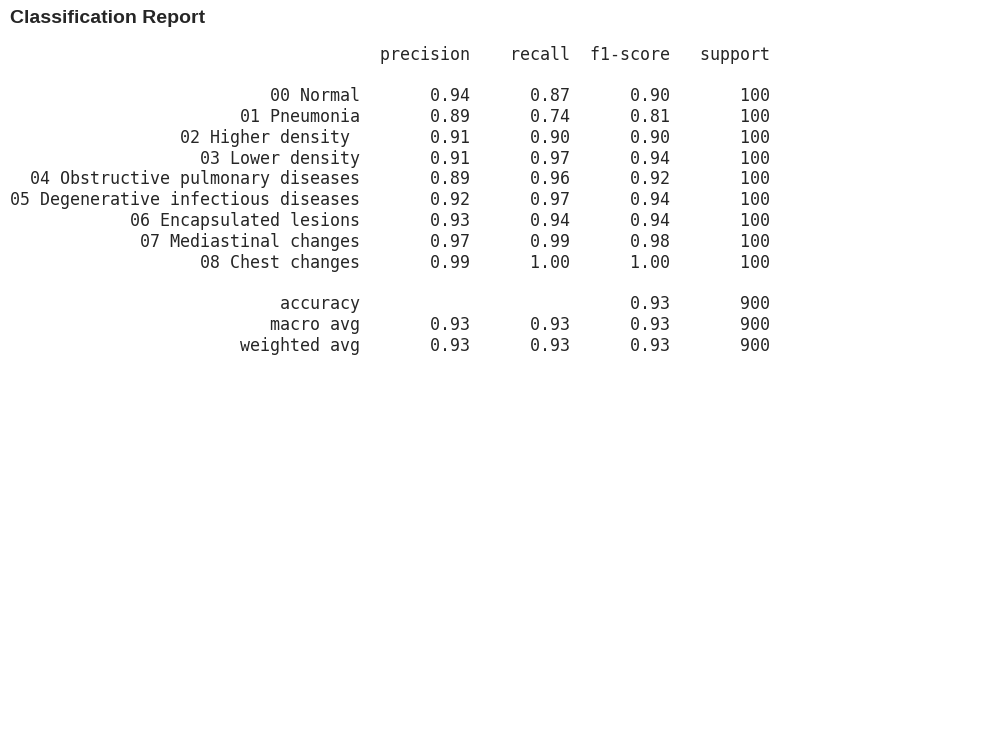

In [85]:
save_classification_report(model, test_ds, class_names, save_path="classification_report_inceptionv3.png")

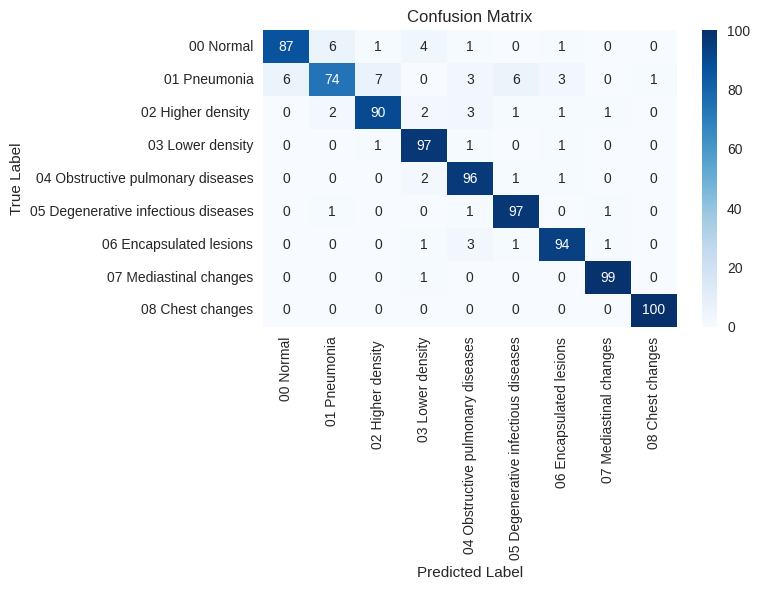

In [86]:
save_confusion_matrix(model, test_ds, class_names, save_path="confusion_matrix_inceptionv3.png")

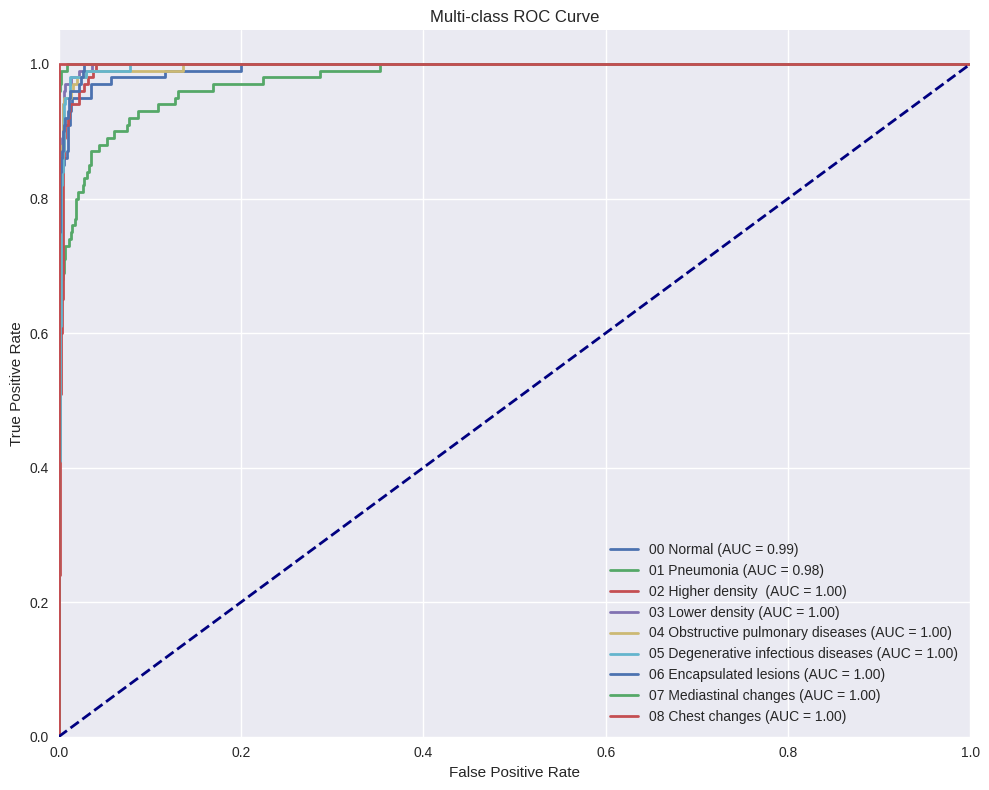

In [87]:
save_auc_roc(model, test_ds, class_names, save_path="auc_roc_inceptionv3.png")

In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

INPUT_SHAPE = (224, 224, 3)  
NUM_CLASSES = 9

def build_resnet_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, train_base=False):
    base_model = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",    
        input_shape=input_shape,
        pooling="avg"
    )
    base_model.trainable = train_base  

    inp = keras.Input(shape=input_shape)
    x = base_model(inp, training=False)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    return model

model = build_resnet_model(train_base=False) 

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [89]:
import time
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        self.total_training_time = time.time() - self.train_start_time


model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

timing_cb = TimingCallback()
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    timing_cb
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=40,
    verbose=1
)

first_epoch_time = timing_cb.epoch_times[0]
avg_epoch_time = sum(timing_cb.epoch_times) / len(timing_cb.epoch_times)
total_training_time = timing_cb.total_training_time

print(f"⏱ First epoch time: {first_epoch_time:.2f} sec")
print(f"⏱ Average epoch time: {avg_epoch_time:.2f} sec")
print(f"⏱ Total training time: {total_training_time:.2f} sec")

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test")

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.3004 - loss: 2.0172 - val_accuracy: 0.6611 - val_loss: 1.1781 - learning_rate: 3.0000e-04
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7173 - loss: 1.0404 - val_accuracy: 0.7789 - val_loss: 0.8668 - learning_rate: 3.0000e-04
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8051 - loss: 0.7804 - val_accuracy: 0.8256 - val_loss: 0.7038 - learning_rate: 3.0000e-04
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8529 - loss: 0.6343 - val_accuracy: 0.8589 - val_loss: 0.5989 - learning_rate: 3.0000e-04
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8802 - loss: 0.5370 - val_accuracy: 0.8833 - val_loss: 0.5243 - learning_rate: 3.0000e-04
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8991 - loss: 0.4664 - val_accuracy: 0.9044 - val_loss: 0.4681 - learning_rate: 3.0000e-04
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - a

✅ Model saved as /kaggle/working/ResNet50V2.h5
✅ Plot saved at: /kaggle/working/ResNet50V2_training_curves.png


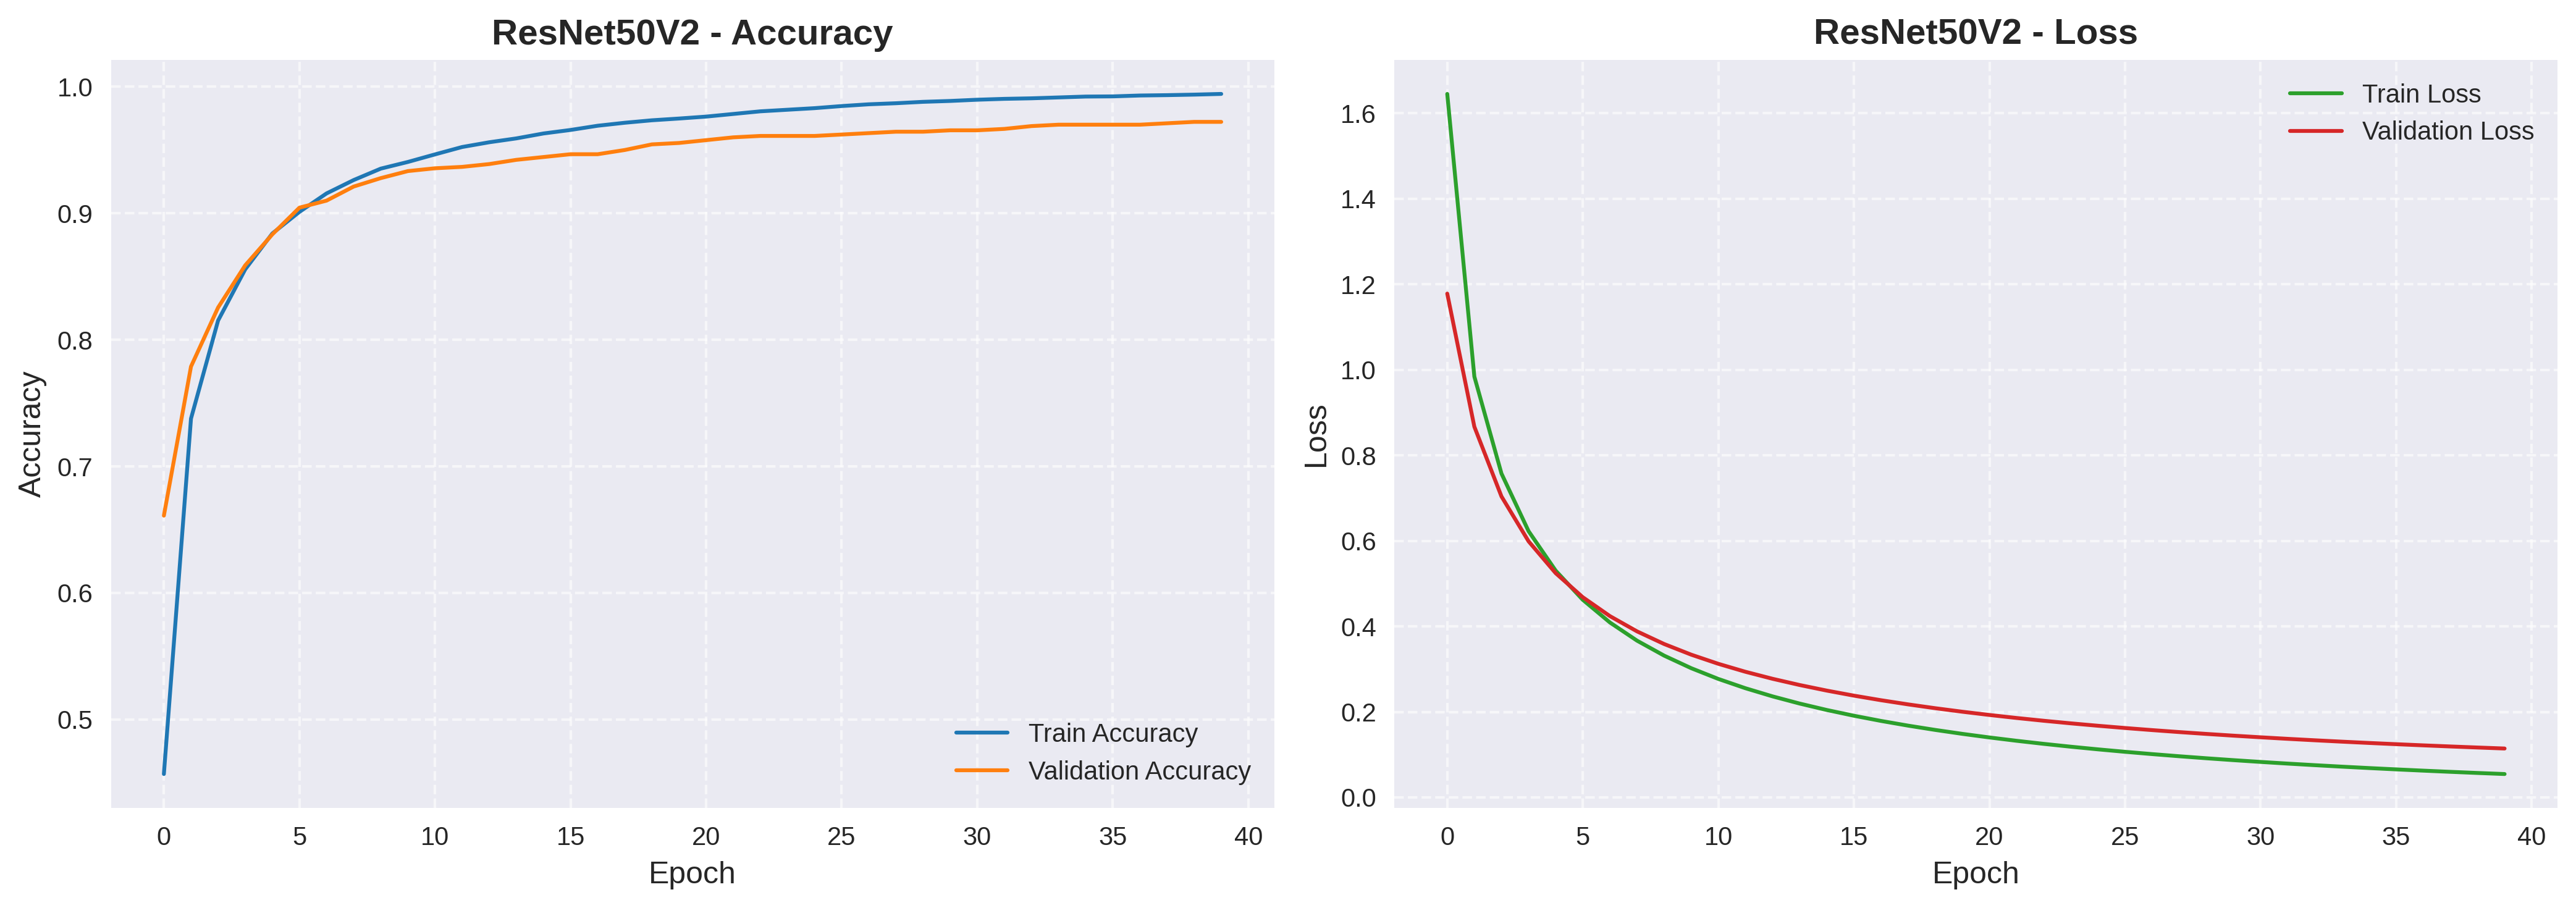

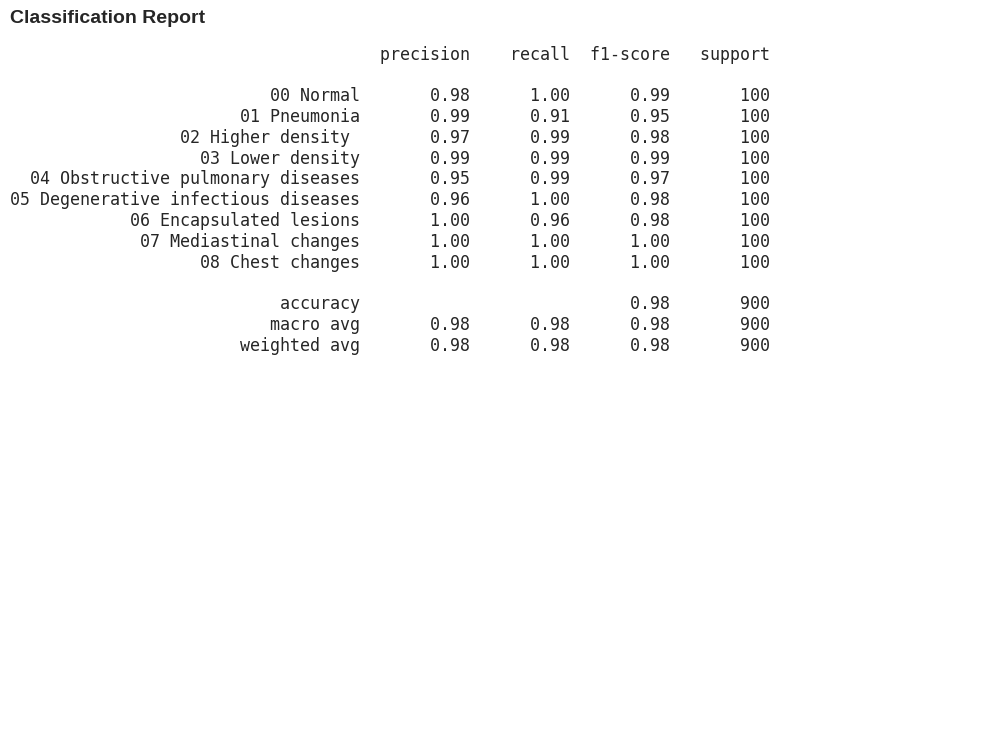

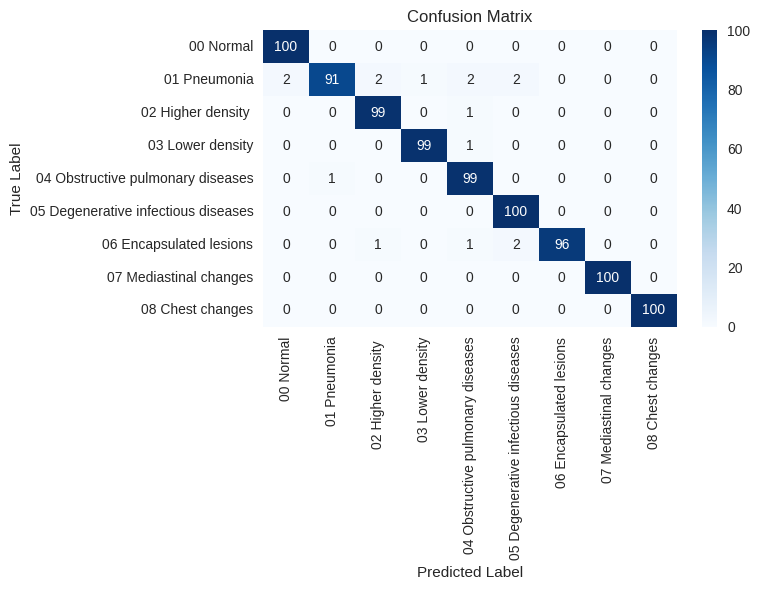

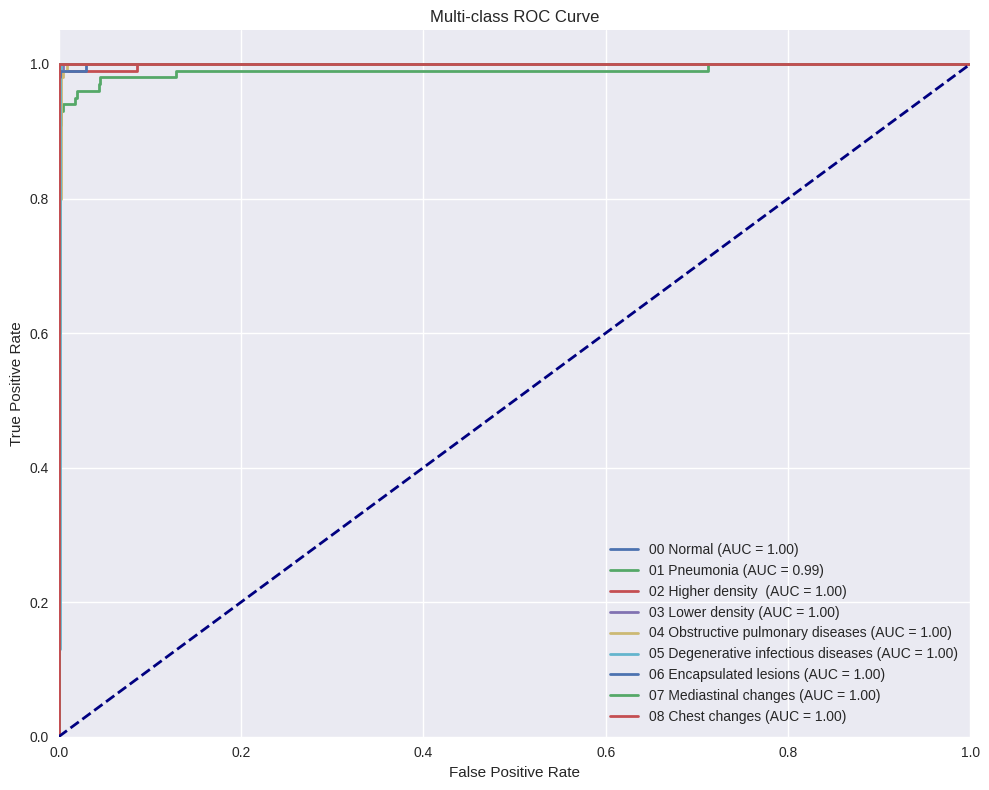

In [90]:
mname = "ResNet50V2"
model.save(f"/kaggle/working/{mname}.h5")

print(f"✅ Model saved as /kaggle/working/{mname}.h5")
plot_training_curves(history, model_name=mname, save_path="/kaggle/working") 
save_classification_report(model, test_ds, class_names, save_path=f"classification_report_{mname}.png")
save_confusion_matrix(model, test_ds, class_names, save_path=f"confusion_matrix_{mname}.png")
save_auc_roc(model, test_ds, class_names, save_path=f"auc_roc_{mname}.png")

In [91]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

INPUT_SHAPE = (224, 224, 3)  
NUM_CLASSES = 9

def build_densenet_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, train_base=False):
    base_model = keras.applications.DenseNet201(
        include_top=False,
        weights="imagenet",    
        input_shape=input_shape,
        pooling="avg"
    )
    base_model.trainable = train_base  

    inp = keras.Input(shape=input_shape)
    x = base_model(inp, training=False)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    return model

model = build_densenet_model(train_base=False) 

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [92]:
import time
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        self.total_training_time = time.time() - self.train_start_time


model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

timing_cb = TimingCallback()
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    timing_cb
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=40,
    verbose=1
)

first_epoch_time = timing_cb.epoch_times[0]
avg_epoch_time = sum(timing_cb.epoch_times) / len(timing_cb.epoch_times)
total_training_time = timing_cb.total_training_time

print(f"⏱ First epoch time: {first_epoch_time:.2f} sec")
print(f"⏱ Average epoch time: {avg_epoch_time:.2f} sec")
print(f"⏱ Total training time: {total_training_time:.2f} sec")

val_results = evaluate_model_with_auc(model, val_ds, "Validation") 
test_results = evaluate_model_with_auc(model, test_ds, "Test") 

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 366ms/step - accuracy: 0.2798 - loss: 1.9629 - val_accuracy: 0.6422 - val_loss: 1.4101 - learning_rate: 3.0000e-04
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.6682 - loss: 1.3105 - val_accuracy: 0.7333 - val_loss: 1.1076 - learning_rate: 3.0000e-04
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7520 - loss: 1.0457 - val_accuracy: 0.7744 - val_loss: 0.9377 - learning_rate: 3.0000e-04
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.8005 - loss: 0.8883 - val_accuracy: 0.8022 - val_loss: 0.8238 - learning_rate: 3.0000e-04
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.8277 - loss: 0.7790 - val_accuracy: 0.8211 - val_loss: 0.7402 - learning_rate: 3.0000e-04
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.8448 - loss: 0.6970 - val_accuracy: 0.8356 - val_loss: 0.6754 - learning_rate: 3.0000e-04
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 1

✅ Model saved as /kaggle/working/DenseNet201.h5
✅ Plot saved at: /kaggle/working/DenseNet201_training_curves.png


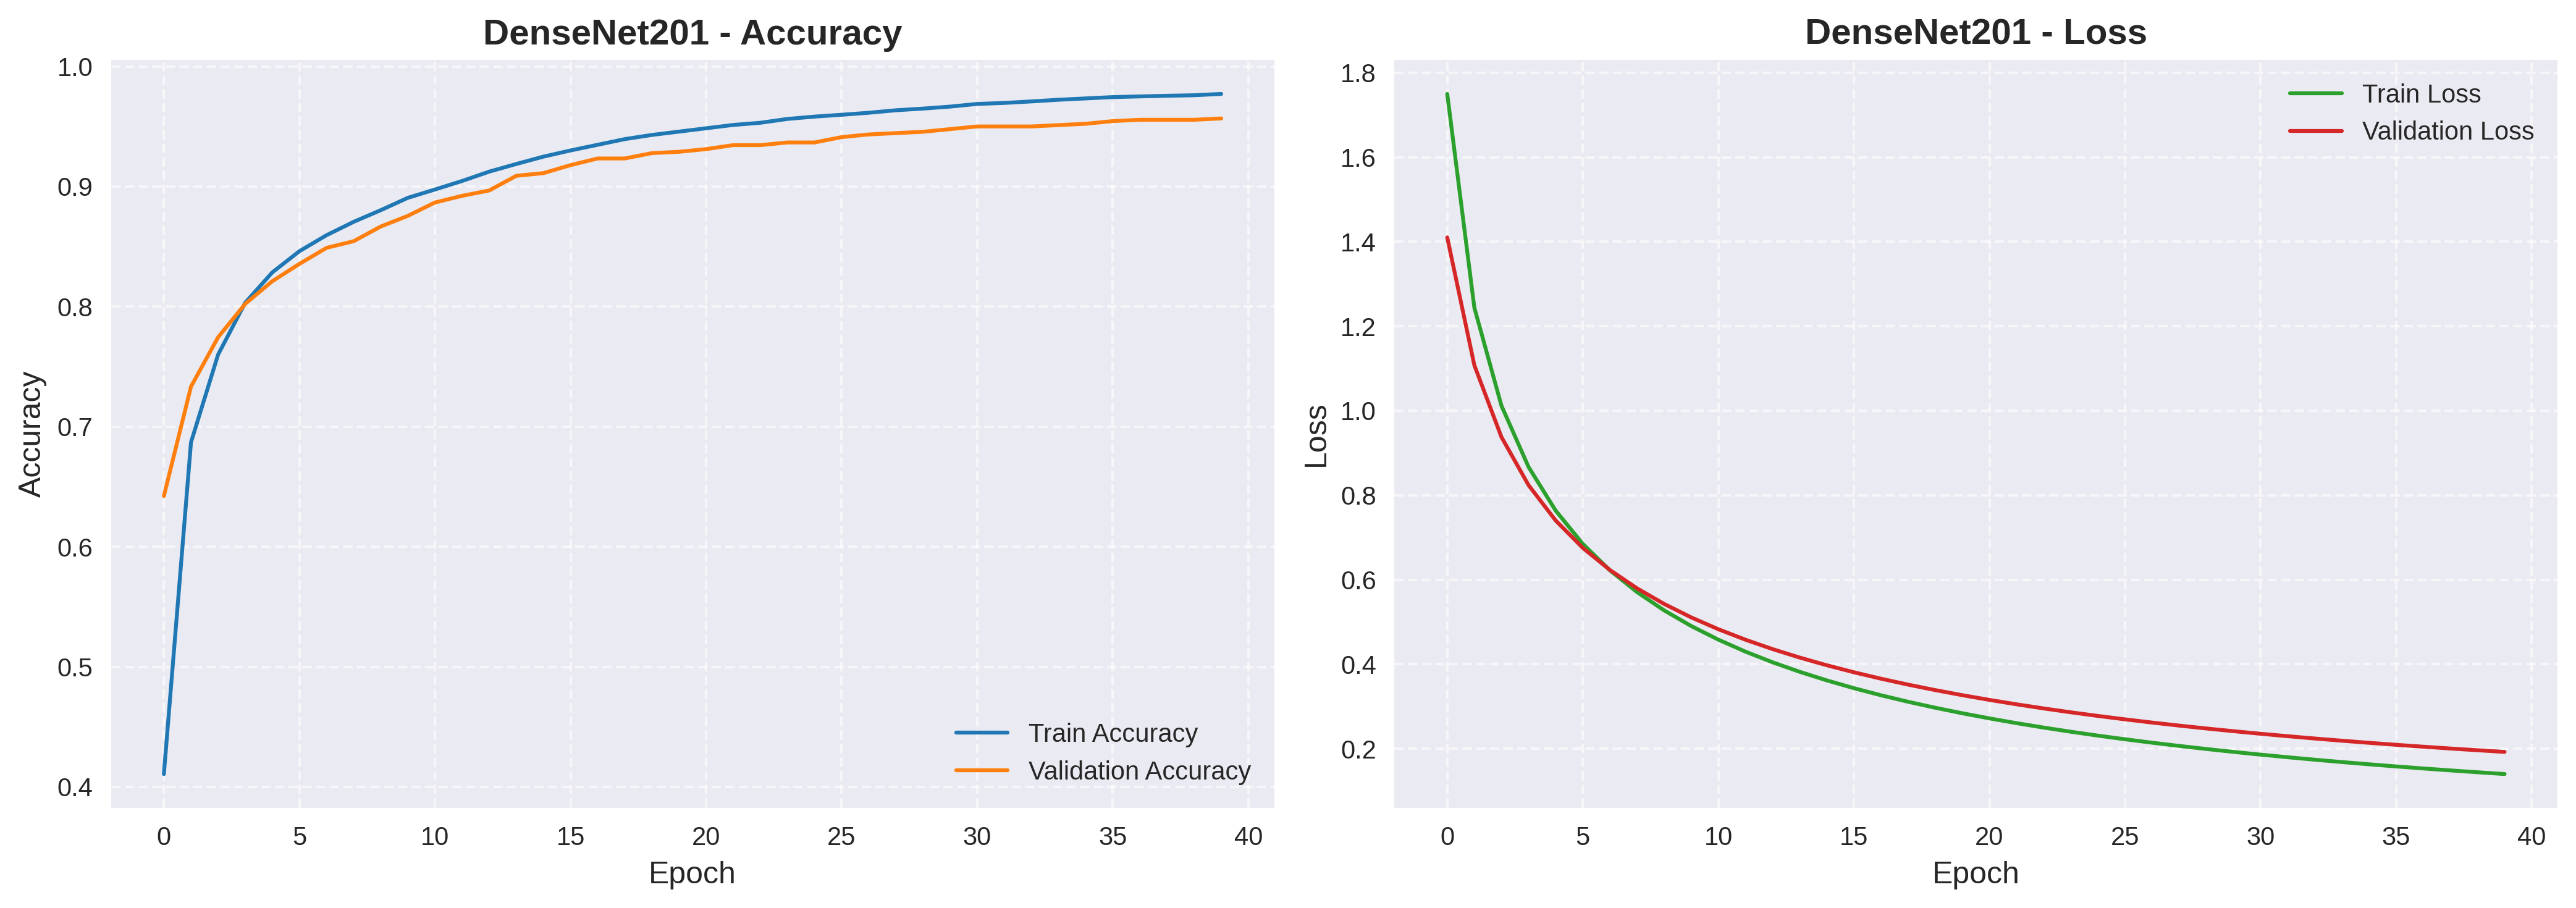

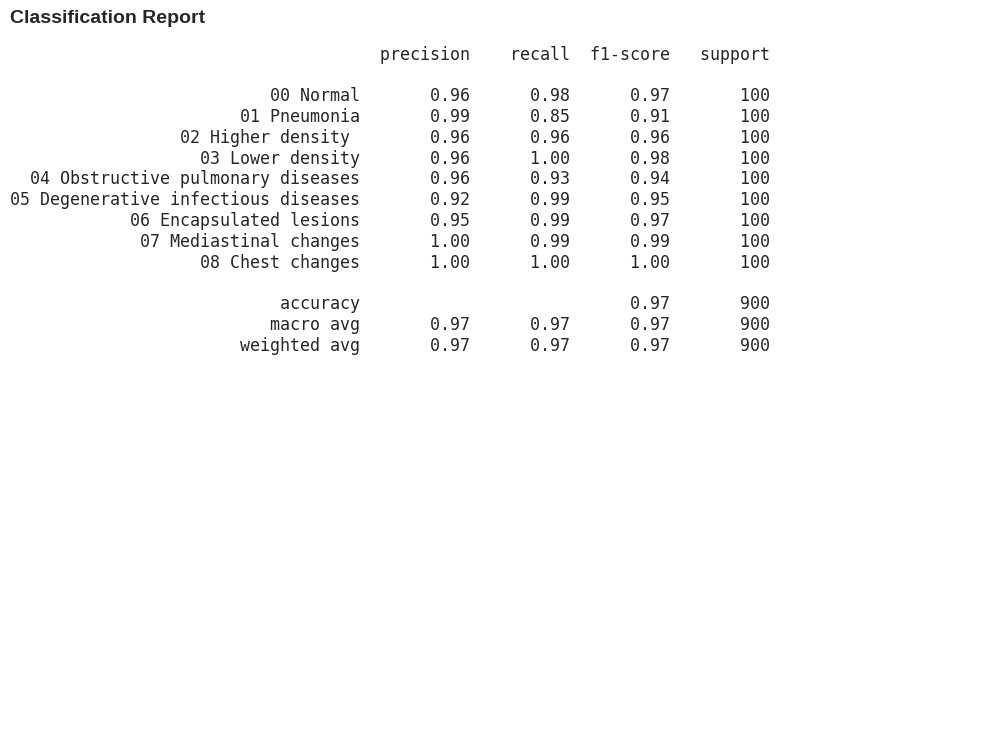

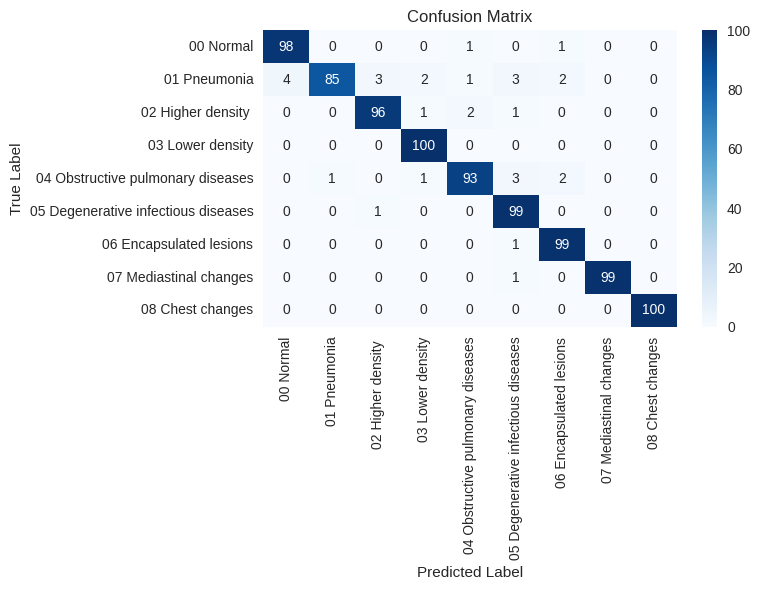

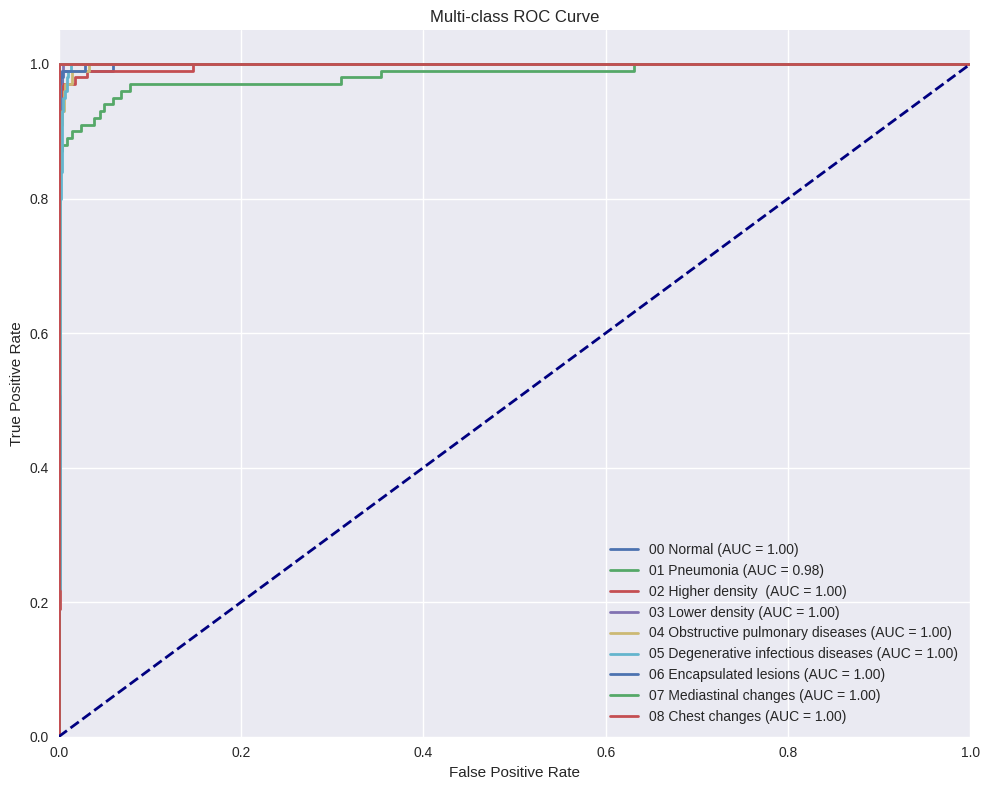

In [93]:
mname = "DenseNet201"
model.save(f"/kaggle/working/{mname}.h5")

print(f"✅ Model saved as /kaggle/working/{mname}.h5")
plot_training_curves(history, model_name=mname, save_path="/kaggle/working") 
save_classification_report(model, test_ds, class_names, save_path=f"classification_report_{mname}.png")
save_confusion_matrix(model, test_ds, class_names, save_path=f"confusion_matrix_{mname}.png")
save_auc_roc(model, test_ds, class_names, save_path=f"auc_roc_{mname}.png") 

# Explainable AI

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


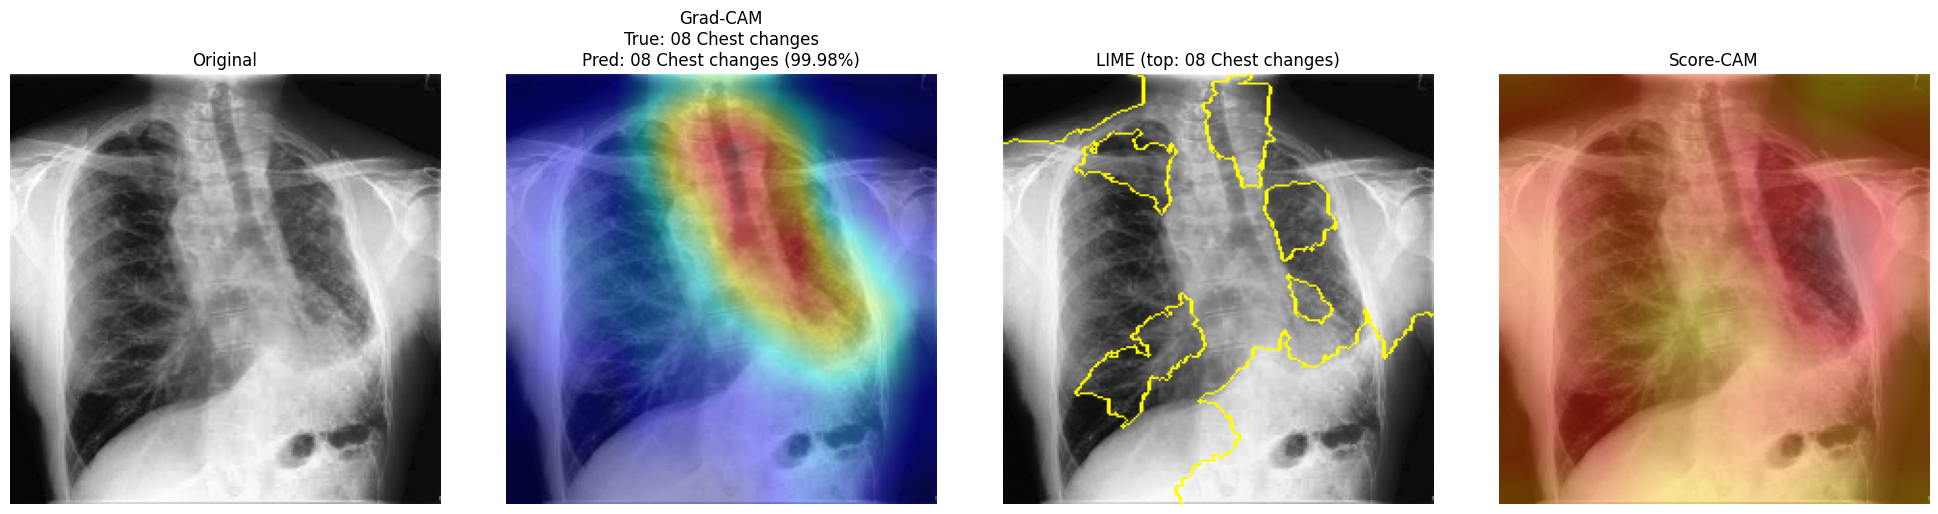

Saved 4-panel row visualization to: all_explanations.png


In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ----------------------------
# Shared helpers
# ----------------------------
def preprocess_for_model(img, target_size=(224, 224)):
    img_resized = cv2.resize(img, target_size)
    img_norm = img_resized.astype("float32") / 255.0
    return np.expand_dims(img_norm, axis=(0, -1))  # (1,H,W,1)

def overlay_heatmap(img_gray_0_255, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img_gray_0_255.shape[1], img_gray_0_255.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    img_color = cv2.cvtColor(img_gray_0_255, cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img_color, 1 - alpha, heatmap_color, alpha, 0)

def _find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found; specify layer_name explicitly.")

# ----------------------------
# Grad-CAM
# ----------------------------
def generate_gradcam(model, img_array, class_index=None, layer_name=None):
    if layer_name is None:
        layer_name = _find_last_conv_layer(model)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy(), predictions.numpy()[0]

# ----------------------------
# Score-CAM
# ----------------------------
def _normalize_heatmap_tensor(hm):
    hm = tf.nn.relu(hm)
    hm = hm / (tf.reduce_max(hm) + tf.keras.backend.epsilon())
    return hm

def generate_scorecam(model, img_array, class_index=None, layer_name=None, batch_size=64, use_softmax=True, channel_limit=None):
    if layer_name is None:
        layer_name = _find_last_conv_layer(model)

    conv_layer = model.get_layer(layer_name)
    activation_model = tf.keras.Model(model.inputs, conv_layer.output)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)  # (1,H,W,1)
    activations = activation_model(img_tensor, training=False)[0]   # (h,w,c)

    h, w, c = activations.shape
    if channel_limit is not None:
        c = min(c, channel_limit)
        activations = activations[:, :, :c]

    act_min = tf.reduce_min(activations, axis=(0,1), keepdims=True)
    act_max = tf.reduce_max(activations, axis=(0,1), keepdims=True)
    denom = tf.where((act_max - act_min) < 1e-12, tf.ones_like(act_max - act_min), (act_max - act_min))
    norm_acts = (activations - act_min) / denom                              # (h,w,c)

    in_h, in_w = img_array.shape[1], img_array.shape[2]
    masks = tf.image.resize(norm_acts, (in_h, in_w), method='bilinear')      # (H,W,C)
    masks = tf.clip_by_value(masks, 0.0, 1.0)

    # Batch of masked inputs
    base_input = img_tensor[0]                                               # (H,W,1)
    masked_inputs = tf.stack([base_input * masks[:, :, k:k+1] for k in range(masks.shape[-1])], axis=0)

    # Predictions
    base_preds = model.predict(img_tensor, verbose=0)[0]
    if class_index is None:
        class_index = int(np.argmax(base_preds))
    preds_masked = model.predict(masked_inputs, batch_size=batch_size, verbose=0)  # (C,num_classes)
    scores = preds_masked[:, class_index]

    if use_softmax:
        scores = tf.nn.softmax(tf.convert_to_tensor(scores)).numpy()
    else:
        scores = scores / (np.sum(scores) + 1e-12)

    heatmap = tf.reduce_sum(norm_acts * scores, axis=-1)                      # (h,w)
    heatmap = _normalize_heatmap_tensor(heatmap)
    return heatmap.numpy(), base_preds, class_index

# ----------------------------
# LIME (image)
# ----------------------------
def make_lime_predict_fn(model):
    def predict_fn(images):
        # LIME passes RGB; convert to gray and preprocess per model
        processed = []
        for img in images:
            if img.ndim == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_input = preprocess_for_model(img)
            processed.append(img_input[0])  # (H,W,1)
        batch = np.stack(processed, axis=0)  # (N,H,W,1)
        return model.predict(batch)
    return predict_fn

# ----------------------------
# Combined visualization
# ----------------------------
def show_all_explanations(
    model,
    img_path,
    class_names,
    true_label=None,                      # can be index or class name string
    layer_name=None,
    target_size=(224,224),
    save_path="all_explanations_row.png",
    dpi=200,
    lime_num_samples=100,
    lime_num_features=10,
    scorecam_channel_limit=None,
    show=True
):
    """
    Generates a 1x4 panel: Original, Grad-CAM, LIME, Score-CAM.
    Saves to `save_path` and optionally shows the figure.

    Returns:
        save_path, pred_label, pred_conf, pred_idx
    """
    # Resolve true_label (accept int or str)
    if isinstance(true_label, str):
        try:
            true_label_idx = class_names.index(true_label)
        except ValueError:
            true_label_idx = None
    else:
        true_label_idx = true_label if isinstance(true_label, int) else None

    # Load grayscale & prep inputs
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise ValueError(f"Could not read image at {img_path}")
    img_resized = cv2.resize(img_gray, target_size)
    img_input = preprocess_for_model(img_gray, target_size=target_size)

    # --- Grad-CAM ---
    hm_gc, preds_gc = generate_gradcam(model, img_input, layer_name=layer_name)
    ov_gc = overlay_heatmap(img_resized, hm_gc)

    # --- Score-CAM ---
    hm_sc, preds_sc, _ = generate_scorecam(
        model, img_input, layer_name=layer_name,
        channel_limit=scorecam_channel_limit
    )
    ov_sc = overlay_heatmap(img_resized, hm_sc)

    # Choose a single prediction summary (from Grad-CAM preds)
    pred_idx = int(np.argmax(preds_gc))
    pred_label = class_names[pred_idx]
    pred_conf = float(preds_gc[pred_idx] * 100.0)

    # Build true label text
    true_text = f"True: {class_names[true_label_idx]}" if true_label_idx is not None else "True: Unknown"

    # --- LIME ---
    img_rgb_for_lime = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_rgb_for_lime,
        make_lime_predict_fn(model),
        top_labels=1,
        hide_color=0,
        num_samples=lime_num_samples
    )
    top_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_class,
        positive_only=True,
        num_features=lime_num_features,
        hide_rest=False
    )
    lime_vis = mark_boundaries(temp, mask)

    # --- Plot 1x4 row ---
    plt.figure(figsize=(20, 5))  # wide row

    # 1) Original
    plt.subplot(1,4,1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # 2) Grad-CAM
    plt.subplot(1,4,2)
    plt.imshow(ov_gc[..., ::-1])  # BGR->RGB
    plt.title(f"Grad-CAM\n{true_text}\nPred: {pred_label} ({pred_conf:.2f}%)")
    plt.axis("off")

    # 3) LIME
    plt.subplot(1,4,3)
    plt.imshow(lime_vis)
    plt.title(f"LIME (top: {class_names[top_class]})")
    plt.axis("off")

    # 4) Score-CAM
    plt.subplot(1,4,4)
    plt.imshow(ov_sc[..., ::-1])  # BGR->RGB
    plt.title("Score-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()

    print(f"Saved 4-panel row visualization to: {save_path}")
    return save_path, pred_label, pred_conf, pred_idx



# e.g. class_names from your dataset
class_names = train_ds_raw.class_names

save_path, pred_label, pred_conf, pred_idx = show_all_explanations(
    model=model,
    img_path="/kaggle/working/splited/test/08 Chest changes/08 (258).jpg",  # <-- your image
    class_names=class_names,
    true_label=8,                          # index or string e.g. "Normal"
    layer_name=None,                       # auto-picks last Conv2D if None
    save_path="all_explanations.png",
    lime_num_samples=100,                  # tweak for stability/quality vs speed
    lime_num_features=10,
    scorecam_channel_limit=None,           # or e.g. 64 to speed up
    show=True
)